In [2]:
from PIL import Image
import os
import numpy as np

def read_images(directory):
    image_data = []
    for file in os.listdir(directory):
        if file.endswith(".jpg"):
            image_path = os.path.join(directory, file)
            image = Image.open(image_path)
            pixel_data = np.array(image)
            image_data.append(pixel_data)
    return image_data

# 128 * 128 images
directory_path = "/kaggle/input/image-classification/images/images/architecure"
image_data_list = read_images(directory_path)
print(f'Number of images: {len(image_data_list)}')

Number of images: 8763


# Create gaussian noise and add it to picture

In [3]:
import random
import math


def gaussian_noise(shape, mean=10, std_dev=10):
    size = np.prod(shape)
    
    u1 = np.random.uniform(0, 1, size)
    u2 = np.random.uniform(0, 1, size)
    
    # Apply the Box-Muller transform to generate Gaussian noise
    z = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    
    # Reshape the noise array to the desired shape
    z = np.reshape(z, shape)
    
    # Scale the noise array by the standard deviation and add the mean
    noise = std_dev * z + mean
    
    return noise


def add_gaussian_noise(image):
    mean = random.randint(10, 30)
    std_dev = random.randint(50, 100)
    noise = gaussian_noise(image.shape, mean=mean, std_dev=std_dev)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

# Result of gaussian noise

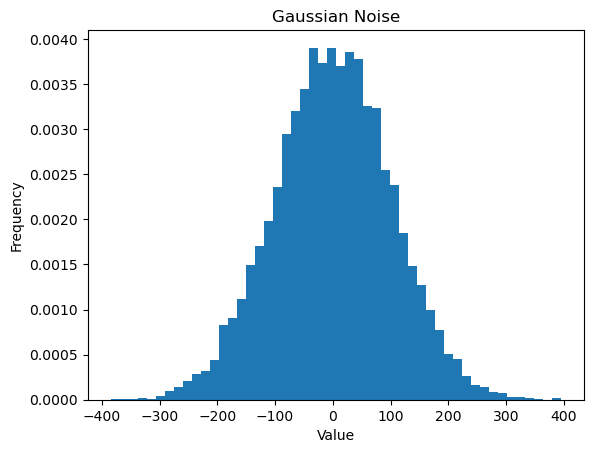

In [4]:
import matplotlib.pyplot as plt

noise = gaussian_noise(shape=10000, mean=0, std_dev=100)

plt.hist(noise, bins=50, density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Gaussian Noise')
plt.show()

# Choose number of pictures to apply noise and denoise

In [5]:
# Choose first 10 images
first_10_images = image_data_list[:10]

Add gaussian noise to images and sotre in new list

In [6]:
# Add Gaussian noise to each image
noisy_images = [add_gaussian_noise(image) for image in first_10_images]

# Plot both original and noised pictures

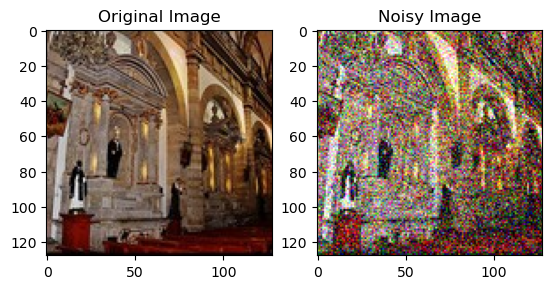

In [7]:
import matplotlib.pyplot as plt

index = random.randint(0, 9)
# Display the first original image and its corresponding noisy image
original_image = Image.fromarray(image_data_list[index])
noisy_image = Image.fromarray(noisy_images[index])
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(noisy_image)
axes[1].set_title("Noisy Image")
plt.show()

# Implementation of SVD function

In [19]:
import numpy as np

def svd(A):
    # Inner product of A^T and A
    ATA = np.dot(A.T, A)

    # Eigenvalues and eigenvectors of A^T.A
    eigenvalues, eigenvectors = np.linalg.eig(ATA)

    # Sort the eigenvalues
    sort_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_indices]
    eigenvectors = eigenvectors[:,sort_indices]

    # Singular values & U.
    sigma = np.sqrt(eigenvalues)
    U = np.dot(A, eigenvectors)
    U = U / sigma

    # Create sigma as a diagonal matrix
    Sigma = np.diag(sigma)

    return U, Sigma, eigenvectors.T

Test the SVD function

In [20]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Implemented SVD
U, SV, V = svd(A)
reconstructed_A = U @ SV @ V
# print(f'U:\n{U}\nSV:\n{SV}\nEigen:\n{Eigen}')

# SVD using np.linalg.svd
U, SV, V = np.linalg.svd(A)
reconstructed_A_with_np = U @ np.diag(SV) @ V

# Check if implemented SVD works fine
print(np.allclose(reconstructed_A, reconstructed_A_with_np))

True
